# Chiens et chats : le grand classique ! 

Passons à un cas plus complexe, mais bien connu dans le domaine du machine learning : la classification d'images entre chat et chien. 

On pourrait penser quie c'est un cas en fait plus simple : MNIST nous demande de classisfier nos images dans 10 classes différentes, alors que chat ou chien est un problème binaire ! 

Mais la complexité ne réside pas dans le nombre de classes mais dans les données à interpréter : 
- On passe de petites images en niveaux de gris à des images dont la taille peut varier, en couleur
- Plus de données centrées sur l'élément d'intérêt : le modèle doit tout seul s'adapter et chercher les zones d'intérêt, qui vont varier d'une image à l'autre ! 

Le niveau d'interprétation nécessaire pour identifier ces images comme comportant des chats ou des chiens est donc bien plus complexe... 

Commençons par nous procurer un dataset ! Il en existe plein, mais nous choisirons un subset du ["Dog Versus Cats" dataset](https://www.kaggle.com/c/dogs-vs-cats/data) disponible sur Kaggle. Ce dataset contient 25 000 images, mais nous nous contenterons d'une plus petite version de 2 000 images. 

Les fichiers sont accessibles en zip via téléchargement, et nous pouvons extraire ces données et les stocker dans le 'tmp' sur google colab. 

Si ce notebook est lancé via une autre interface, il peut être nécessaire de modifier les chemins d'accès pour le téléchargement et les interactions avec le zip. 

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2022-02-10 10:46:01--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.157.128, 142.251.8.128, 74.125.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.157.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   142MB/s    in 0.5s    

2022-02-10 10:46:02 (142 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Le contenu du zip est maintenant disponible dans le répertoire `tmp/cats_and_dogs_filtered` . Ce dossier possède des répertoires `train` et `validation` qui seront utilisés pour l'entrainement, et qui se divisent encore en sous-répertoires : `cats` et `dogs`  

In [ ]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## Visusalisation des données 

Les données sont donc réparties entre entrainement et validation, et chats et chiens. Ici, ce qui joue le rôle de label, c'est le dossier qui contient l'image. Une image dans le dossier `tmp/cats_and_dogs_filtered/train/cats` sera donc logiquement une image d'un chat. 

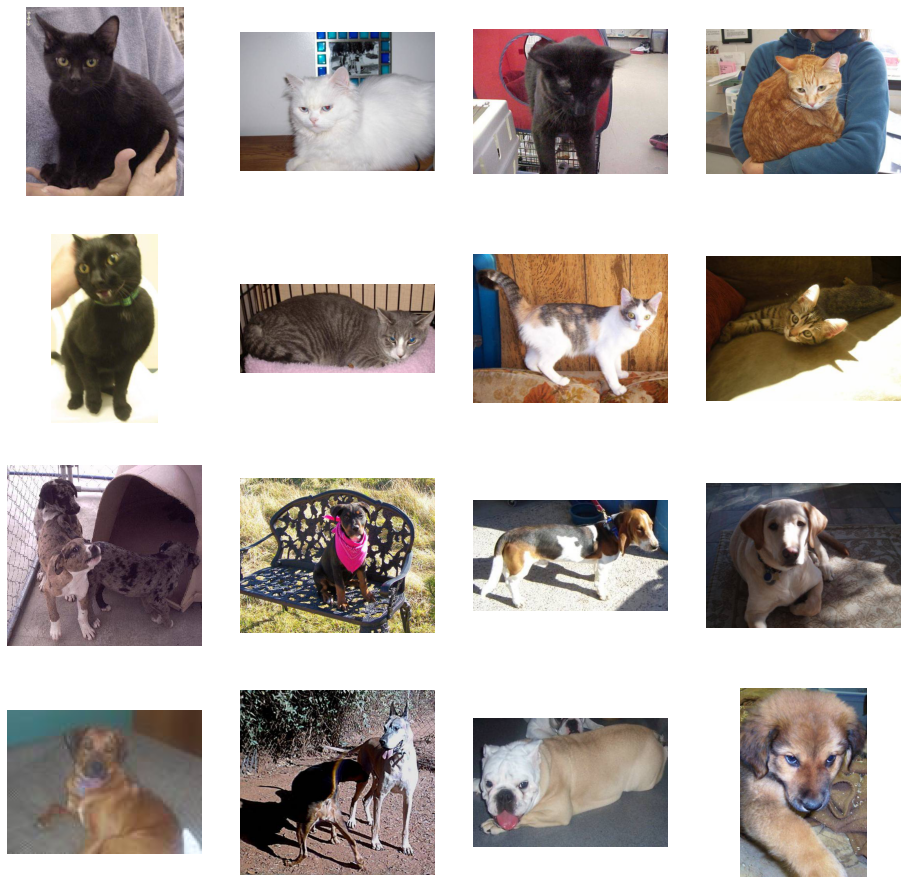

Size of one random image : (499, 333, 3)


In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

print("Size of one random image : {}".format(img.shape))

On observe : 
- des images disparates : de taille et nature différente 
- une variation entre les races des deux espèces

Ce dataset ne contient pas d'images en même temps de chats et de chiens : il faudrait rajouter un nouveau dossier. Mais que se passerait-il si un modèle entrainé rencontrait des images comportant chat et chien en même temps ? 



## Exploration et formattage des données 

Passons à l'exploration des données. 

Commençons par étudier le format des données, la répartition, et ce que les données peuvent nous dire ! 




In [ ]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


On a déjà vu que les images n'avaient pas une taille constante dans ce dataset. Il faudra pourtant les ramener tous à une même taille, puisque le modèle ne peut pas se permettre de faire varier sa forme d'entrée. Nous devrons donc passer par une étape de formattage de ces données. 

De même que pour le MNIST, nous ramènerons aussi les valeurs des pixels entre 0 et 1 au lieu de les conserver entre 0 et 255. 

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(150, 150),  
        batch_size=20,
        class_mode='binary')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Qu'avons-nous fait dans les lignes précédentes ? Reprenons ... 



```
# train_datagen = ImageDataGenerator(rescale=1./255)
```
Cette ligne déclare un outil de preprocessing d'images en keras : l'ImageDataGenerator. Cet outil permettra de générer des batchs images à partir d'un dossier, ce qui en fait un outil idéal pour notre situation. On lui passe en paramètre une transformation qui permet de ramener la valeur des pixels entre 0 et 1.

Passons à la génération des batchs d'images : 


```
# train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(150, 150),  
        batch_size=20,
        class_mode='binary')
```

On utilise la méthode 'flow_from_directory' qui permet de faire un générateur à partir d'un dossier d'images. On renseigne : 
- le dossier en question
- la taille des images que nous souhaitons atteindre (ici : 150*150)
- la taille du batch que le générateur devra fournir 
- le type de labels qui sera généré. Ici, nous faisons de la classification binaire, donc 'binary' suffira.


Passons au modèle ! 

# Un modèle pour les discerner tous ! 

Comment faire un modèle qui réussira à reconnaitre si un chien ou un chat est sur l'image qu'on lui fournit ? 

Commençons par utiliser ce que nous maitrisons ! 

## Le réseau de neurones dense 

Utilisons le même modèle que l'on a utilisé à la base pour le MNIST précédent, en adaptant la forme en entrée pour les nouvelles images et la forme en sortie pour la classification binaire : 


In [ ]:
from keras import layers 
from keras import models 

network1 = models.Sequential()
network1.add(layers.Dense(32, activation = 'relu', input_shape= (150,150,3,)))
network1.add(layers.Dense(1, activation = 'sigmoid'))

Et observons à quoi il ressemble avec le méthode `summary` : 

In [ ]:
network1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 150, 150, 32)      128       
                                                                 
 dense_1 (Dense)             (None, 150, 150, 1)       33        
                                                                 
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________


Eh là ! La dernière couche est de dimension 4, alors que l'on souhaite une couche de dimension 2 ! Pour rappel, dans le modèle précédent, nous avions la forme (None,10) à la sortie pour une classification à 10 choix. 

C'est la nouvelle forme des données en entrée qui semble nous faire défaut ici. Nous pouvons imaginer deux solutions : 
- Refaire une modification des données pour les mettre dans la même forme que pour le MNIST (Rappel : nous nous étions débarassés de la dimension multiple des données avec la commande `train_images = train_images.reshape((60000,28*28))`)
- Rajouter des étapes dans le modèle pour que les couches aient une forme adaptée 

Nous allons voir qu'il est possible de faire une opération pratique sur les couches : une 'projection à plat '

In [ ]:
from keras import layers 
from keras import models 

network2 = models.Sequential()
network2.add(layers.Dense(32, activation = 'relu', input_shape= (150,150,3,)))
network2.add(layers.Flatten())
network2.add(layers.Dense(1, activation = 'sigmoid'))


In [ ]:
network2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 150, 150, 32)      128       
                                                                 
 flatten (Flatten)           (None, 720000)            0         
                                                                 
 dense_3 (Dense)             (None, 1)                 720001    
                                                                 
Total params: 720,129
Trainable params: 720,129
Non-trainable params: 0
_________________________________________________________________


Et voilà ! La forme en sortie est bel et bien (None,1) maintenant ! 

Mais que fait exactement la couche Flatten() ? Elle mets les input 'à plat'. C'est une forme de `reshape` automatique ! 

On observera tout de même une différence majeure entre les réseaux `network` et `network2` : le nombre de paramètres ! En effet, après la couche Flatten(), il est nécessaire d'avoir autant de paramètres qu'il y a d'éléments dans la couche ... 

## Nouveau problème, nouvelle perte 

Il faut encore une fois définir ce dont nous avons besoin en fonction de perte et en optimizer. Le problème est toujours un problème de classification, alors pourquoi ne pas réutiliser la `categorical_crossentropy` utilisée précedemment ? Eh bien, parce qu'il y a une fonction spéciale pour le cas binaire, appelée `binary_crossentropy` ! 

Tous les problèmes n'ont pas bien sur leurs propres pertes déjà encodées dans une bibliothèque de keras. Mais tant qu'il est possible, et tant que nous ne cherchons pas à optimiser jusqu'à l'état de l'art nos modèles, utiliser les fonctions de perte classiques est une solution simple et pratique. 

In [ ]:
from tensorflow.keras.optimizers import RMSprop

network2.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

## S'entrainer à partir de générateurs 

Nous avons plus haut fabriqué ce qu'on appelle un générateur d'images. Comment utiliser ce dernier pour que les données soient fournis au réseau pour l'entrainement ? 

Il existe une méthode simple pour cela, appelée `fit_generator`. On lui passe en paramètre : 
- le générateur de données d'entrainement 
- le nombre d'étapes pour considérer qu'on a fait le tour des données (une epoch)
- le nombre de fois où nous fournirons toutes les données au modèle (nombre d'epochs)
- le générateur de données de validation 
- le nombre d'étapes pour considérer qu'on a fait le tour des données de validation 

RAPPEL : La validation, c'est le principe de faire un test après chaque époque (entrainement sur le jeu de données d'entrainement entier) avec des données qui ne servent pas à l'entrainement. L'optimizer utilisera le score de perte d'entrainement pour calculer les modifications à faire sur les poids. Ceci est une mesure qui permet : 
- de constater l'overfitting (surentrainement) lorsqu'il y en a 
- de limiter ce dernier 



In [ ]:
epochs = 15


history2 = network2.fit_generator(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


100/100 - 18s - loss: 7.8421 - acc: 0.5185 - val_loss: 2.3098 - val_acc: 0.5250 - 18s/epoch - 177ms/step
Epoch 2/15
100/100 - 12s - loss: 1.1666 - acc: 0.5995 - val_loss: 0.7413 - val_acc: 0.6220 - 12s/epoch - 116ms/step
Epoch 3/15
100/100 - 9s - loss: 0.6355 - acc: 0.6895 - val_loss: 0.7338 - val_acc: 0.6610 - 9s/epoch - 94ms/step
Epoch 4/15
100/100 - 9s - loss: 0.5404 - acc: 0.7505 - val_loss: 0.7562 - val_acc: 0.6580 - 9s/epoch - 93ms/step
Epoch 5/15
100/100 - 9s - loss: 0.4644 - acc: 0.7790 - val_loss: 0.8187 - val_acc: 0.6460 - 9s/epoch - 92ms/step
Epoch 6/15
100/100 - 11s - loss: 0.4102 - acc: 0.8325 - val_loss: 0.8510 - val_acc: 0.6480 - 11s/epoch - 115ms/step
Epoch 7/15
100/100 - 9s - loss: 0.3492 - acc: 0.8560 - val_loss: 0.8981 - val_acc: 0.6280 - 9s/epoch - 92ms/step
Epoch 8/15
100/100 - 10s - loss: 0.3097 - acc: 0.8830 - val_loss: 0.9252 - val_acc: 0.6360 - 10s/epoch - 102ms/step
Epoch 9/15
100/100 - 9s - loss: 0.2613 - acc: 0.9105 - val_loss: 1.0111 - val_acc: 0.6300 - 9s/

Deux cas de figure sont possible ici : 


*   Soit on est tombé sur un cas de mauvaise initialisation, et le modèle n'a pas appris grand chose : il a une précision de 50%, ce qui correspond en binaire à de l'aléatoire 
*   Soit on est tombés sur un bon cas d'initialisation, et alors le modèle a réussi à apprendre ! Néanmoins, les courbes pour les données d'entrainement et de validation ne se suivent pas : le modèle n'apprend pas la généralisation, il se spécialise sur les données d'entraînement ! C'est ce qu'on appelle le surapprentissage (overfitting). 




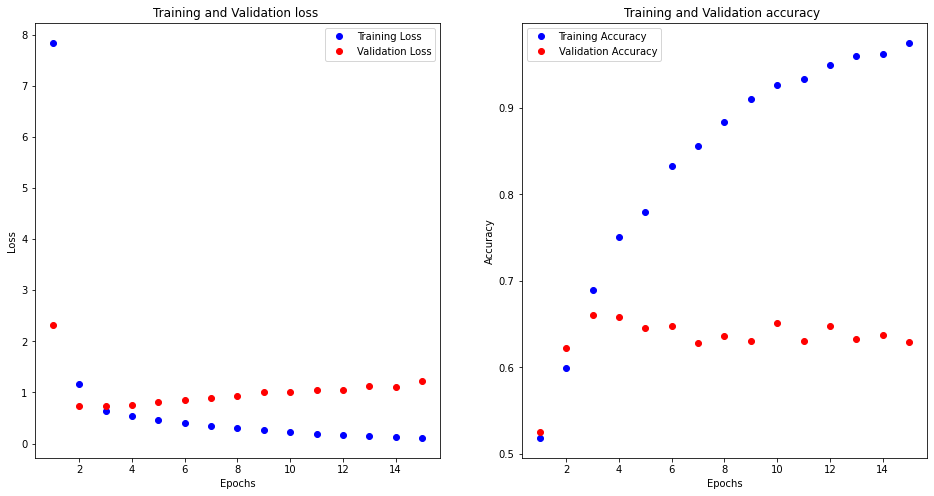

In [ ]:
history_dict = history2.history 
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
plt.rcParams['figure.figsize'] = (16,8) # Make the figures a bit bigger
fig,(ax1,ax2,) = plt.subplots(1,2)

x = range(1,epochs+1)
ax1.plot(x,loss_values,'bo',label='Training Loss')
ax1.plot(x,val_loss_values,'ro',label='Validation Loss')
ax1.set_title('Training and Validation loss ')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()


ax2.plot(x,acc_values,'bo',label='Training Accuracy')
ax2.plot(x,val_acc_values,'ro',label='Validation Accuracy')
ax2.set_title('Training and Validation accuracy ')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

Selon le cas décrit précedemment, on a soit aucune tendance sur ces courbes, soit une dégradation des performances des données de validation au fur et à mesure que le réseau apprend. 

Nous allons voir dans la suite d'autre types de structures de réseaux de neurones et des techniques qui permettront de mieux traiter les images et de lutter contre les phénomènes d'overfitting ! 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/15
100/100 - 16s - loss: 10.3757 - acc: 0.5480 - val_loss: 0.8707 - val_acc: 0.5920 - 16s/epoch - 163ms/step
Epoch 2/15
100/100 - 11s - loss: 0.7138 - acc: 0.6340 - val_loss: 0.7292 - val_acc: 0.6290 - 11s/epoch - 107ms/step
Epoch 3/15
100/100 - 11s - loss: 0.5754 - acc: 0.7250 - val_loss: 0.7576 - val_acc: 0.6030 - 11s/epoch - 106ms/step
Epoch 4/15
100/100 - 10s - loss: 0.4839 - acc: 0.7740 - val_loss: 0.7985 - val_acc: 0.6300 - 10s/epoch - 105ms/step
Epoch 5/15
100/100 - 11s - loss: 0.4072 - acc: 0.8250 - val_loss: 0.9073 - val_acc: 0.5980 - 11s/epoch - 105ms/step
Epoch 6/15
100/100 - 10s - loss: 0.3457 - acc: 0.8585 - val_loss: 0.8740 - val_acc: 0.6340 - 10s/epoch - 104ms/step
Epoch 7/15
100/100 - 11s - loss: 0.2805 - acc: 0.8905 - val_loss: 1.0101 - val_acc: 0.6250 - 11s/epoch - 107ms/step
Epoch 8/15
100/100 - 11s - loss: 0.2381 - acc: 0.9155 - val_loss: 1.1149 - val_acc: 0.6280 - 11s/epoch - 105ms/step
Epoch 9/15
100/100 - 11s - loss: 0.1908 - acc: 0.9345 - val_loss: 1.178

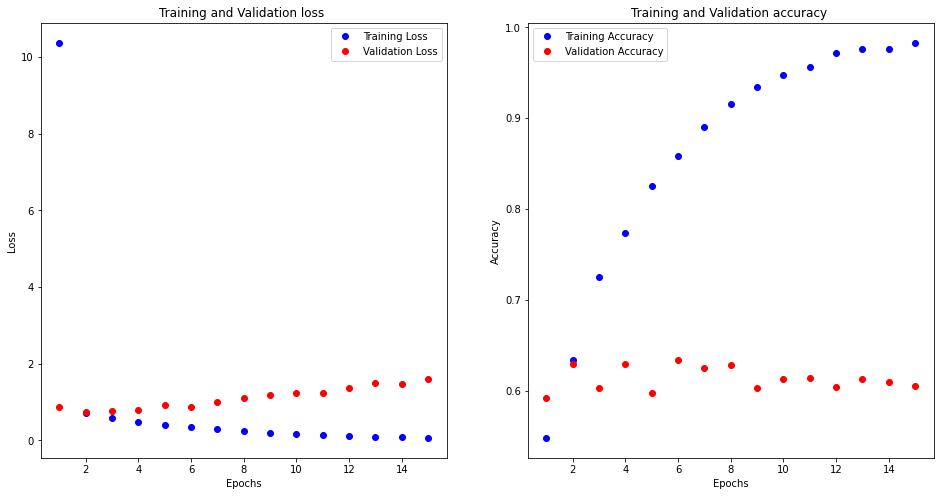

In [ ]:
# Paramètres modifiables 
epochs = 15
nodes = 128 
optimizer='rmsprop'

model = models.Sequential()
model.add(layers.Dense(nodes, activation = 'relu', input_shape= (150,150,3,)))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

model.summary()

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2)

history_dict = history.history 
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
plt.rcParams['figure.figsize'] = (16,8) # Make the figures a bit bigger
fig,(ax1,ax2,) = plt.subplots(1,2)

x = range(1,epochs+1)
ax1.plot(x,loss_values,'bo',label='Training Loss')
ax1.plot(x,val_loss_values,'ro',label='Validation Loss')
ax1.set_title('Training and Validation loss ')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()


ax2.plot(x,acc_values,'bo',label='Training Accuracy')
ax2.plot(x,val_acc_values,'ro',label='Validation Accuracy')
ax2.set_title('Training and Validation accuracy ')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()